In [1]:
import os
import sys
import pandas as pd
import numpy as np
from importlib import reload
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from jinja2 import Template
import sqlalchemy
import yaml
%matplotlib inline

In [2]:
def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..','config'), 'elsal_db_profile2.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)
conn = connect()

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
query = Template("""
WITH 
mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_ovg
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)

-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_0_to_1,
       r.base_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      r.train_end_time AS train_end_time,
      r.past_train_end_time AS past_train_end_time,
      r.list_size, metric, parameter,
      r.value AS value,
      r.max_recall_ratio AS max_recall_ratio,
      r.recall_0_to_1 AS recall_0_to_1,
      r.recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.composite_results_ovg r
WHERE train_end_time > past_train_end_time
;
""")

In [4]:
query_mg = Template("""
WITH pf_mgs AS (
    SELECT distinct(model_group_id)
    FROM triage_metadata.models mm
    WHERE mm.built_by_experiment IN ('b4e0da3f19e7457b5d42b9c6d5d0f082', '4c02ae8079370278e72c1ab1baa102d7')
),
mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_ovg
  JOIN pf_mgs using(model_group_id)
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)

-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_0_to_1,
       r.base_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.model_adjustment_results_ovg r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      r.train_end_time AS train_end_time,
      r.past_train_end_time AS past_train_end_time,
      r.list_size, metric, parameter,
      r.value AS value,
      r.max_recall_ratio AS max_recall_ratio,
      r.recall_0_to_1 AS recall_0_to_1,
      r.recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.composite_results_ovg r
WHERE train_end_time > past_train_end_time
;
""")

In [5]:
query_decoupled = Template("""
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_ovg
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)


-- -- Composite model (with decoupled models)
SELECT 'Composite w/ Decoupled - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      r.recall_0_to_1 AS recall_0_to_1,
      r.recall_1_to_0 AS recall_1_to_0
FROM {{schema}}.composite_results_decoupled_ovg r
WHERE train_end_time > past_train_end_time
;
""")

In [6]:
params = {}
params['schema'] = 'bias_analysis_v2_original'
sql_orig = query_mg.render(**params)
ts_df_orig = pd.read_sql(sql_orig, conn)

params = {}
params['schema'] = 'bias_analysis_v2_zafar'
sql_zafar = query.render(**params)
ts_df_zafar = pd.read_sql(sql_zafar, conn)

params = {}
params['schema'] = 'bias_analysis_v2_under_1_orig_orig'
sql_v1a = query_mg.render(**params)
ts_df_v1a = pd.read_sql(sql_v1a, conn)

params = {}
params['schema'] = 'bias_analysis_v2_under_orig_50_50'
sql_v2a = query_mg.render(**params)
ts_df_v2a = pd.read_sql(sql_v2a, conn)

params = {}
params['schema'] = 'bias_analysis_v2_under_orig_snop_orig'
sql_v2b = query_mg.render(**params)
ts_df_v2b = pd.read_sql(sql_v2b, conn)

params = {}
params['schema'] = 'bias_analysis_v2_under_orig_50_orig'
sql_v2c = query_mg.render(**params)
ts_df_v2c = pd.read_sql(sql_v2c, conn)

params = {}
params['schema'] = 'bias_analysis_v2_under_1_snop_orig'
sql_v3a = query_mg.render(**params)
ts_df_v3a = pd.read_sql(sql_v3a, conn)

params = {}
params['schema'] = 'bias_analysis_v2_under_1_50_50'
sql_v3b = query_mg.render(**params)
ts_df_v3b = pd.read_sql(sql_v3b, conn)

params = {}
params['schema'] = 'bias_analysis_v2_over_1_orig_orig'
sql_o_v1a = query_mg.render(**params)
ts_df_o_v1a = pd.read_sql(sql_o_v1a, conn)

params = {}
params['schema'] = 'bias_analysis_v2_over_orig_50_50'
sql_o_v2a = query_mg.render(**params)
ts_df_o_v2a = pd.read_sql(sql_o_v2a, conn)

params = {}
params['schema'] = 'bias_analysis_v2_over_orig_snop_orig'
sql_o_v2b = query_mg.render(**params)
ts_df_o_v2b = pd.read_sql(sql_o_v2b, conn)

params = {}
params['schema'] = 'bias_analysis_v2_over_orig_50_orig'
sql_o_v2c = query_mg.render(**params)
ts_df_o_v2c = pd.read_sql(sql_o_v2c, conn)

params = {}
params['schema'] = 'bias_analysis_v2_over_1_snop_orig'
sql_o_v3a = query_mg.render(**params)
ts_df_o_v3a = pd.read_sql(sql_o_v3a, conn)

params = {}
params['schema'] = 'bias_analysis_v2_over_1_50_50'
sql_o_v3b = query_mg.render(**params)
ts_df_o_v3b = pd.read_sql(sql_o_v3b, conn)

params = {}
params['schema'] = 'bias_analysis_v2_nop'
sql_nop = query.render(**params)
ts_df_nop = pd.read_sql(sql_nop, conn)

params = {}
params['schema'] = 'bias_analysis_v2_decoupled'
sql_decoupled = query_decoupled.render(**params)
ts_df_decoupled = pd.read_sql(sql_decoupled, conn)

In [7]:
ts_df_nop['dataset'] = 'NoP'
nop_df = ts_df_nop.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_decoupled['dataset'] = 'Decoupled'
decoupled_df = ts_df_decoupled.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_zafar['dataset'] = 'Zafar'
zafar_df = ts_df_zafar.rename(
    {'recall_1_to_0': 'recall_disp'}, axis='columns')

In [8]:
ts_df_orig['dataset'] = 'Original'
orig_df = ts_df_orig.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v1a['dataset'] = 'U-v1a'
u_v1a_df = ts_df_v1a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v2a['dataset'] = 'U-v2a'
u_v2a_df = ts_df_v2a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v2b['dataset'] = 'U-v2b'
u_v2b_df = ts_df_v2b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v2c['dataset'] = 'U-v2c'
u_v2c_df = ts_df_v2c.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v3a['dataset'] = 'U-v3a'
u_v3a_df = ts_df_v3a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_v3b['dataset'] = 'U-v3b'
u_v3b_df = ts_df_v3b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

In [9]:
ts_df_o_v1a['dataset'] = 'O-v1a'
o_v1a_df = ts_df_o_v1a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v2a['dataset'] = 'O-v2a'
o_v2a_df = ts_df_o_v2a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v2b['dataset'] = 'O-v2b'
o_v2b_df = ts_df_o_v2b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v2c['dataset'] = 'O-v2c'
o_v2c_df = ts_df_o_v2c.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v3a['dataset'] = 'O-v3a'
o_v3a_df = ts_df_o_v3a.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

ts_df_o_v3b['dataset'] = 'O-v3b'
o_v3b_df = ts_df_o_v3b.rename(
    {'recall_1_to_0': 'recall_disp'
    }, axis='columns')

In [10]:
nonsamp_df = pd.concat([orig_df, nop_df, zafar_df, decoupled_df])
usamp_df = pd.concat([orig_df, u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df])
osamp_df = pd.concat([orig_df, o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

In [11]:
print(len(orig_df), len(nop_df), len(ts_df_zafar), len(ts_df_decoupled), 
      len(u_v1a_df), len(u_v2a_df), len(u_v2b_df), len(u_v2c_df), len(u_v3a_df), len(u_v3b_df),
     len(o_v1a_df), len(o_v2a_df), len(o_v2b_df), len(o_v2c_df), len(o_v3a_df), len(o_v3b_df))

45 39 39 5 39 39 39 39 39 39 39 57 39 39 39 39


In [12]:
pd.value_counts(o_v2a_df['strategy'])

Best Unadjusted Metric - Adjusted      17
Best Adjusted Metric - Adjusted        17
Best Unadjusted Metric - Unadjusted    17
Composite Model - Adjusted              6
Name: strategy, dtype: int64

In [13]:
pd.value_counts(o_v2b_df['strategy'])

Best Unadjusted Metric - Adjusted      11
Best Adjusted Metric - Adjusted        11
Best Unadjusted Metric - Unadjusted    11
Composite Model - Adjusted              6
Name: strategy, dtype: int64

In [14]:
o_v2a_df

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_0_to_1,recall_disp,dataset
0,Best Unadjusted Metric - Unadjusted,2011-01-01,2010-01-01,10000,precision@,10000_abs,0.386889,1.403972,1.403972,0.712265,O-v2a
1,Best Unadjusted Metric - Unadjusted,2011-01-01,2010-01-01,10000,precision@,10000_abs,0.386889,1.403972,1.403972,0.712265,O-v2a
2,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.237162,1.850995,1.850995,0.540250,O-v2a
3,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.237162,1.850995,1.850995,0.540250,O-v2a
4,Best Unadjusted Metric - Unadjusted,2013-01-01,2012-01-01,10000,precision@,10000_abs,0.363614,2.941792,0.339929,2.941792,O-v2a
5,Best Unadjusted Metric - Unadjusted,2013-01-01,2012-01-01,10000,precision@,10000_abs,0.363614,2.941792,0.339929,2.941792,O-v2a
6,Best Unadjusted Metric - Unadjusted,2011-01-01,2010-01-01,10000,precision@,10000_abs,0.404298,1.612020,1.612020,0.620340,O-v2a
7,Best Unadjusted Metric - Unadjusted,2011-01-01,2010-01-01,10000,precision@,10000_abs,0.404298,1.612020,1.612020,0.620340,O-v2a
8,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.243403,2.019012,2.019012,0.495292,O-v2a
9,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.243403,2.019012,2.019012,0.495292,O-v2a


In [15]:
def plot_figure_two(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    #data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected", 
                                                                                        "Sampling (Best Equity)",
                                                                                       "Sampling (Best Precision)",
                                                                                       "Composite Adjusted",
                                                                                       "Regularization", 
                                                                                  "Post-hoc Adjustment"]).reset_index()

    unique_dfs = ["Original", "No Protected", "Sampling (Best Equity)", "Sampling (Best Precision)",
                 "Composite Adjusted", "Regularization", "Post-hoc Adjustment"]
    
    colorlist = ['#001c7f', #Original
                 '#b1400d', #No_Protected
                 '#12711c', #Best Sampling(Equity)
                 #'#8c0800', #OLD -Best Sampling(Precision)
                 '#7CFC00', #NEW - Best Sampling(Precision)
                 '#591e71', #Composite Adjustment
                 '#592f0d', #Regularization
                 '#a23582' #Post-hoc Adjustment
                ]

    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    #unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('')
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0, 1.0], [1.0, 1.0], linestyle='--', color='black')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=24)
    ax.get_legend().remove()
    
    '''
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    #ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    #ax.set_xlim([0.5, 0.58])
    '''
    ax.set_xlim([0.4, 0.58])
    ax.set_yscale('log')
    fig.tight_layout()

In [75]:
usamp_df.groupby(['dataset','strategy'])[['value', 'recall_disp']].mean()

value  recall_disp
dataset  strategy                                                  
Original Best Adjusted Metric - Adjusted      0.491477     0.950085
         Best Unadjusted Metric - Adjusted    0.481215     0.958159
         Best Unadjusted Metric - Unadjusted  0.486710     2.776569
         Composite Model - Adjusted           0.506168     0.780071
U-v1a    Best Adjusted Metric - Adjusted      0.410473     1.204290
         Best Unadjusted Metric - Adjusted    0.410473     1.204290
         Best Unadjusted Metric - Unadjusted  0.416587     2.388661
         Composite Model - Adjusted           0.407683     0.957704
U-v2a    Best Adjusted Metric - Adjusted      0.428127     1.013838
         Best Unadjusted Metric - Adjusted    0.434291     0.978587
         Best Unadjusted Metric - Unadjusted  0.437610     2.042147
         Composite Model - Adjusted           0.422467     0.905801
U-v2b    Best Adjusted Metric - Adjusted      0.469182     0.964601
         Best Unadjusted Metric - Adjusted    0.469800     0.973305
         Best Unadjusted Metric - Unadjusted  0.471948     1.663433
         Composite Model - Adjusted           0.488883     0.792788
U-v2c    Best Adjusted Metric - Adjusted      0.499609     0.916312
         Best Unadjusted Metric - Adjusted    0.499645     0.924849
         Best Unadjusted Metric - Unadjusted  0.504140     2.459461
         Composite Model - Adjusted           0.508167     0.774308
U-v3a    Best Adjusted Metric - Adjusted      0.427218     1.069611
         Best Unadjusted Metric - Adjusted    0.429764     1.094405
         Best Unadjusted Metric - Unadjusted  0.428359     0.874532
         Composite Model - Adjusted           0.431100     0.915464
U-v3b    Best Adjusted Metric - Adjusted      0.374127     1.292829
         Best Unadjusted Metric - Adjusted    0.374127     1.292829
         Best Unadjusted Metric - Unadjusted  0.384529     3.369787
         Composite Model - Adjusted           0.375067     1.030332

In [76]:
osamp_df.groupby(['dataset','strategy'])[['value', 'recall_disp']].mean()

value  recall_disp
dataset  strategy                                                  
O-v1a    Best Adjusted Metric - Adjusted      0.374864     1.229956
         Best Unadjusted Metric - Adjusted    0.374864     1.229956
         Best Unadjusted Metric - Unadjusted  0.385302     3.395048
         Composite Model - Adjusted           0.351067     1.165975
O-v2a    Best Adjusted Metric - Adjusted      0.367276     1.152335
         Best Unadjusted Metric - Adjusted    0.367276     1.152335
         Best Unadjusted Metric - Unadjusted  0.369306     1.554181
         Composite Model - Adjusted           0.418240     0.852504
O-v2b    Best Adjusted Metric - Adjusted      0.456582     0.966687
         Best Unadjusted Metric - Adjusted    0.456582     0.966687
         Best Unadjusted Metric - Unadjusted  0.456952     1.303305
         Composite Model - Adjusted           0.462567     0.826335
O-v2c    Best Adjusted Metric - Adjusted      0.495200     0.930506
         Best Unadjusted Metric - Adjusted    0.495200     0.930506
         Best Unadjusted Metric - Unadjusted  0.496385     1.534662
         Composite Model - Adjusted           0.498317     0.791976
O-v3a    Best Adjusted Metric - Adjusted      0.418055     1.087416
         Best Unadjusted Metric - Adjusted    0.419091     1.087261
         Best Unadjusted Metric - Unadjusted  0.417705     1.272560
         Composite Model - Adjusted           0.429850     1.026315
O-v3b    Best Adjusted Metric - Adjusted      0.466518     0.941273
         Best Unadjusted Metric - Adjusted    0.465636     0.955891
         Best Unadjusted Metric - Unadjusted  0.466385     1.019930
         Composite Model - Adjusted           0.472050     0.941490
Original Best Adjusted Metric - Adjusted      0.491477     0.950085
         Best Unadjusted Metric - Adjusted    0.481215     0.958159
         Best Unadjusted Metric - Unadjusted  0.486710     2.776569
         Composite Model - Adjusted           0.506168     0.780071

In [16]:
#fig_two_df = pd.concat([orig_df, nop_df, zafar_df, decoupled_df])

filtered_original_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_original_df.loc[:,'dataset'] = 'Original'
filtered_original_df.loc[:,'strategy'] = 'No Adjustment'

filtered_adjusted_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Adjusted')]
filtered_adjusted_df.loc[:,'dataset'] = 'Post-hoc Adjustment'
filtered_adjusted_df.loc[:,'strategy'] = 'Post-hoc Adjustment'

filtered_composite_df = orig_df[(orig_df['strategy'] == 'Composite Model - Adjusted')]
filtered_composite_df.loc[:,'dataset'] = 'Composite Adjusted'
filtered_composite_df.loc[:,'strategy'] = 'Composite Adjusted'

filtered_nop_df = nop_df[nop_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_nop_df.loc[:,'dataset'] = 'No Protected'
filtered_nop_df.loc[:,'strategy'] = 'No Protected'

filtered_zafar_df = zafar_df[zafar_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_zafar_df.loc[:,'dataset'] = 'Regularization'
filtered_zafar_df.loc[:,'strategy'] = 'Regularization'

best_prec_df = u_v2c_df[u_v2c_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
best_prec_df.loc[:,'dataset'] = 'Sampling (Best Precision)'
best_prec_df.loc[:,'strategy'] = 'Sampling (Best Precision)'

best_equity_df = o_v3b_df[o_v3b_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
best_equity_df.loc[:,'dataset'] = 'Sampling (Best Equity)'
best_equity_df.loc[:,'strategy'] = 'Sampling (Best Equity)'

fig_two_df = pd.concat([filtered_original_df, filtered_nop_df, filtered_zafar_df, 
                        best_prec_df, best_equity_df, filtered_adjusted_df,
                       filtered_composite_df])

fig_three_df = pd.concat([filtered_original_df, filtered_nop_df])
fig_four_df = pd.concat([filtered_original_df, filtered_zafar_df])

filtered_decoupled_df = decoupled_df[(decoupled_df['strategy'] == 'Composite w/ Decoupled - Adjusted')]
filtered_decoupled_df.loc[:,'strategy'] = 'Decoupled'
filtered_decoupled_df.loc[:,'dataset'] = 'Decoupled'

fig_five_df = pd.concat([filtered_original_df, filtered_composite_df, filtered_decoupled_df])

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


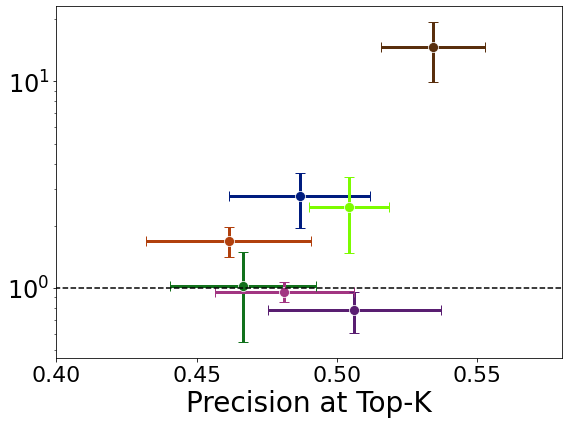

In [17]:
plot_figure_two(fig_two_df)
plt.savefig('../../PLOTS2/PLOTS_Summary/ElSal_Methods_New.pdf')

In [187]:
def plot_figure_three(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', #Original
                 '#b1400d']
    unique_dfs = ["Original", "No Protected"]
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "No Protected"]
        
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=24, 
              bbox_to_anchor=(0.01, 0.95
                             ), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.set_xlim([0.35, 0.55])
    ax.set_ylim([0.7, 3.85])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

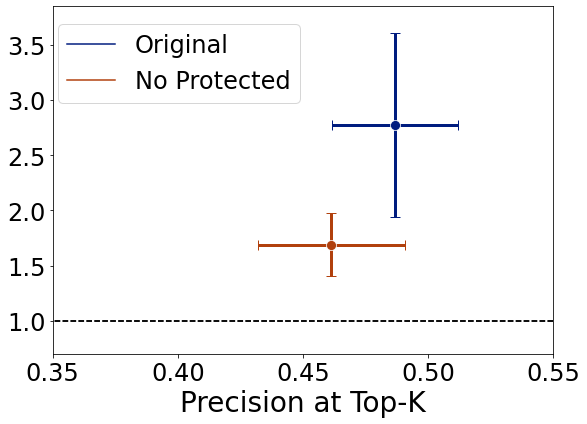

In [188]:
plot_figure_three(fig_three_df)
plt.savefig('../../PLOTS2/PLOTS_NOP/NoP_Elsal.pdf')

In [189]:
def plot_figure_four(comp_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Regularization"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', '#592f0d'] #Regularization
    
    unique_dfs = ["Original", "Regularization"]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
    
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=24, 
              bbox_to_anchor=(0.015, 0.95), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)

    
    ax.set_ylim([-1, 20])
    ax.set_xlim([0.4, 0.6])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

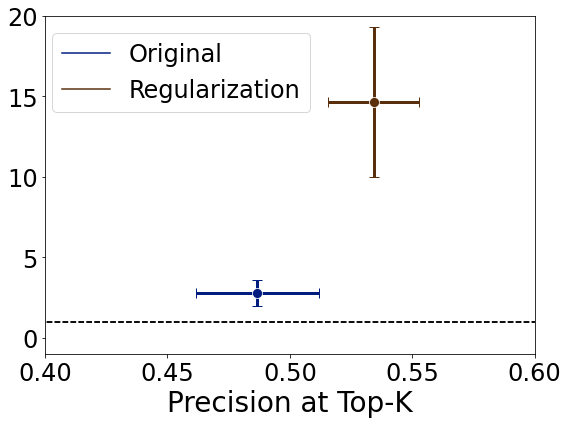

In [190]:
plot_figure_four(fig_four_df)
plt.savefig('../../PLOTS2/PLOTS_Zafar/elsal_zafar.pdf')

In [195]:
def plot_figure_five(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Composite Adjusted", "Decoupled"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                 '#591e71', # Composite Adjustment
                 '#3c3c3c' # Decoupled
                ]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Composite Adjusted", "Decoupled"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=20, 
              bbox_to_anchor=(0.015, 0.975), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.set_ylim([0.7, 4])
    ax.set_xlim([0.35, 0.58])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    #ax.legend().remove()
    fig.tight_layout()

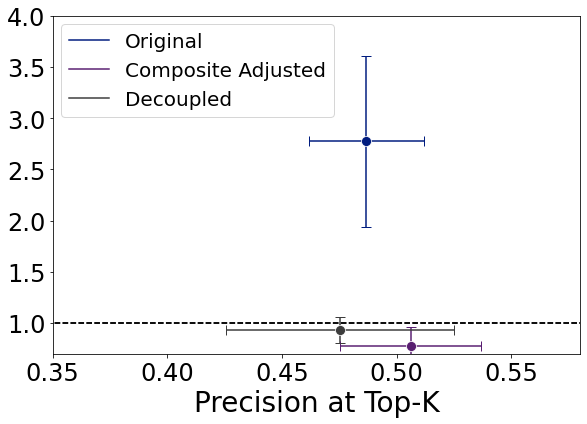

In [196]:
plot_figure_five(fig_five_df)
plt.savefig('../../PLOTS2/PLOTS_Composite/Composite_ElSal.pdf')

In [154]:
def get_mode(x):
    if "Original" in x:
        return "Original"
    elif "U" in x:
        return "Under"
    return "Over"

usamp_df = pd.concat([u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df])
osamp_df = pd.concat([o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_usamp_df = usamp_df[(usamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_osamp_df = osamp_df[(osamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]

fig_six_df = pd.concat([filtered_orig_df, filtered_usamp_df, filtered_osamp_df])
fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='Original', 'mode'] = 'Original'
fig_six_df.loc[fig_six_df['dataset']=='U-v1a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='U-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='U-v2a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='U-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='U-v2b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='U-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='U-v2c', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='U-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='U-v3a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='U-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='U-v3b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='U-v3b', 'dataset'] = '6'

fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='O-v1a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='O-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='O-v2a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='O-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='O-v2b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='O-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='O-v2c', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='O-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='O-v3a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='O-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='O-v3b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='O-v3b', 'dataset'] = '6'

fig_six_df = fig_six_df.rename(columns={"dataset": "Method", "mode":"Mode"})

In [155]:
fig_six_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()

,Method,Mode,value,recall_disp
0,Original,Original,0.486710,2.776569
1,1,Under,0.416587,2.388661
2,2,Under,0.437610,2.042147
3,3,Under,0.471948,1.663433
4,4,Under,0.504140,2.459461
5,5,Under,0.428359,0.874532
6,6,Under,0.384529,3.369787
7,1,Over,0.385302,3.395048
8,2,Over,0.369306,1.554181
9,3,Over,0.456952,1.303305


In [215]:
def plot_figure_six(comp_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    colorlist = ['#001c7f', #Original
                 '#12711c', 
                 #'#23fab9', 
                 #'#00875e',
                 #'#3fb9c4',
                 '#a2ff00']
                 #'#688c29']
    
    data = comp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'Mode',
                 style = 'Method',
                 markers = True,
                 palette = colorlist,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = [("Original","Original"),
                  ("1","Under"), ("1","Over"),
                  ("2","Under"),("2","Over"),
                  ("3","Under"),("3","Over"),
                  ("4","Under"),("4","Over"),
                  ("5","Under"),("5","Over"),
                  ("6","Under"),("6","Over")]
    
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[(comp_df['Method'] == unique_dfs[i][0]) & (comp_df['Mode']==unique_dfs[i][1]), ].copy()
        
        x_coords = list(tmp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        
        prec_errors = 1.96*tmp_df.groupby(['Method', 'Mode'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['Method', 'Mode'])['recall_disp'].sem().values
    
        mode = unique_dfs[i][1]
        if mode == "Original":
            color = colorlist[0]
        elif mode == "Under":
            color = colorlist[1]
        else:
            color = colorlist[2]
            
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = color, fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    #for i, lab in enumerate(labels):
    #    if lab not in list(unique_dfs):
    #        handles[i].set_linestyle("")
    #        lab = "Methods"
    #    hhandles.append(handles[i])
    #    llabels.append(lab)

    ax.legend(handles, labels, fontsize=18, 
              bbox_to_anchor=(0.015, 0.975), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    ax.set_xlim([0.225, 0.55])
    fig.tight_layout()

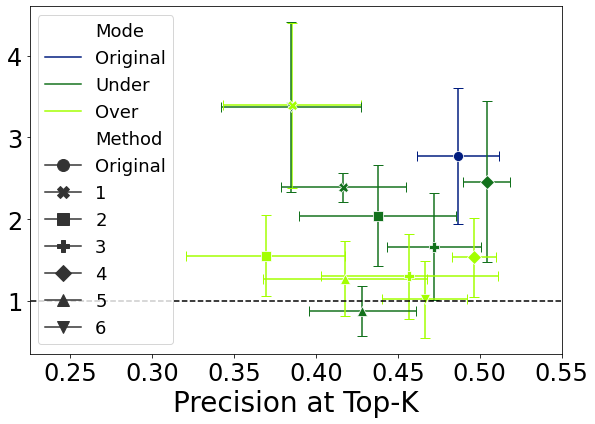

In [216]:
plot_figure_six(fig_six_df)
plt.savefig('../../PLOTS2/PLOTS_Sampling/ElSal_Sampling.pdf')

In [163]:
fig_six_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()

,Method,Mode,value,recall_disp
0,Original,Original,0.486710,2.776569
1,1,Under,0.416587,2.388661
2,2,Under,0.437610,2.042147
3,3,Under,0.471948,1.663433
4,4,Under,0.504140,2.459461
5,5,Under,0.428359,0.874532
6,6,Under,0.384529,3.369787
7,1,Over,0.385302,3.395048
8,2,Over,0.369306,1.554181
9,3,Over,0.456952,1.303305


In [158]:
fig_seven_df = pd.concat([filtered_orig_df, filtered_adjusted_df])

In [219]:
def plot_figure_seven(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Post-hoc Adjustment"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                '#a23582']

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Post-hoc Adjustment"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    llabels = ['Methods', 'Original', 'Post-hoc\nAdjustment']
    ax.legend(hhandles[1:], llabels[1:], fontsize=20, 
              bbox_to_anchor=(0.01, 0.985), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.set_ylim([0.8, 4])
    ax.set_xlim([0.4, 0.52])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    #ax.legend().remove()
    fig.tight_layout()

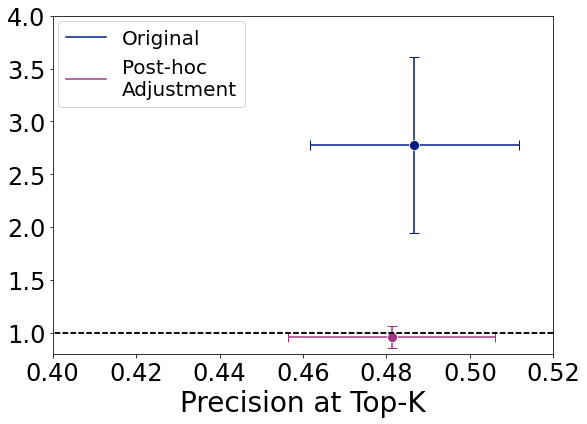

In [220]:
plot_figure_seven(fig_seven_df)
plt.savefig('../../PLOTS2/PLOTS_Post/elsal_post.pdf')